**Introduction to Retrieval Arguement Generation**

**In this section, we will:**

1. Discuss shortcomings of generative language models, which help motivate RAG
show how external knowledge sources can give language models long-term memory (and help them focus on what they’re good at).

2. Explain the fundamental principles of retrieval-augmented generation, or RAG

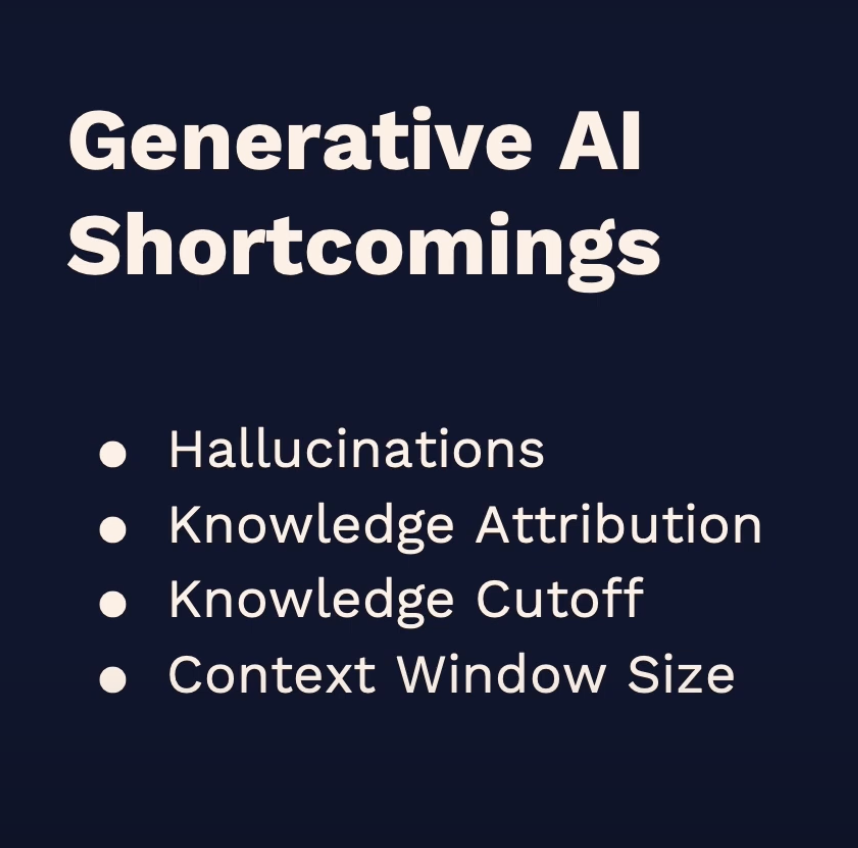

Welcome to this exercise on using Chromadb, an open-source vector database, for semantic search.
Chroma is an open-source vector database that allows us to efficiently store and query high-dimensional vectors,
such as those generated by large language models like the one we’ll be using today.


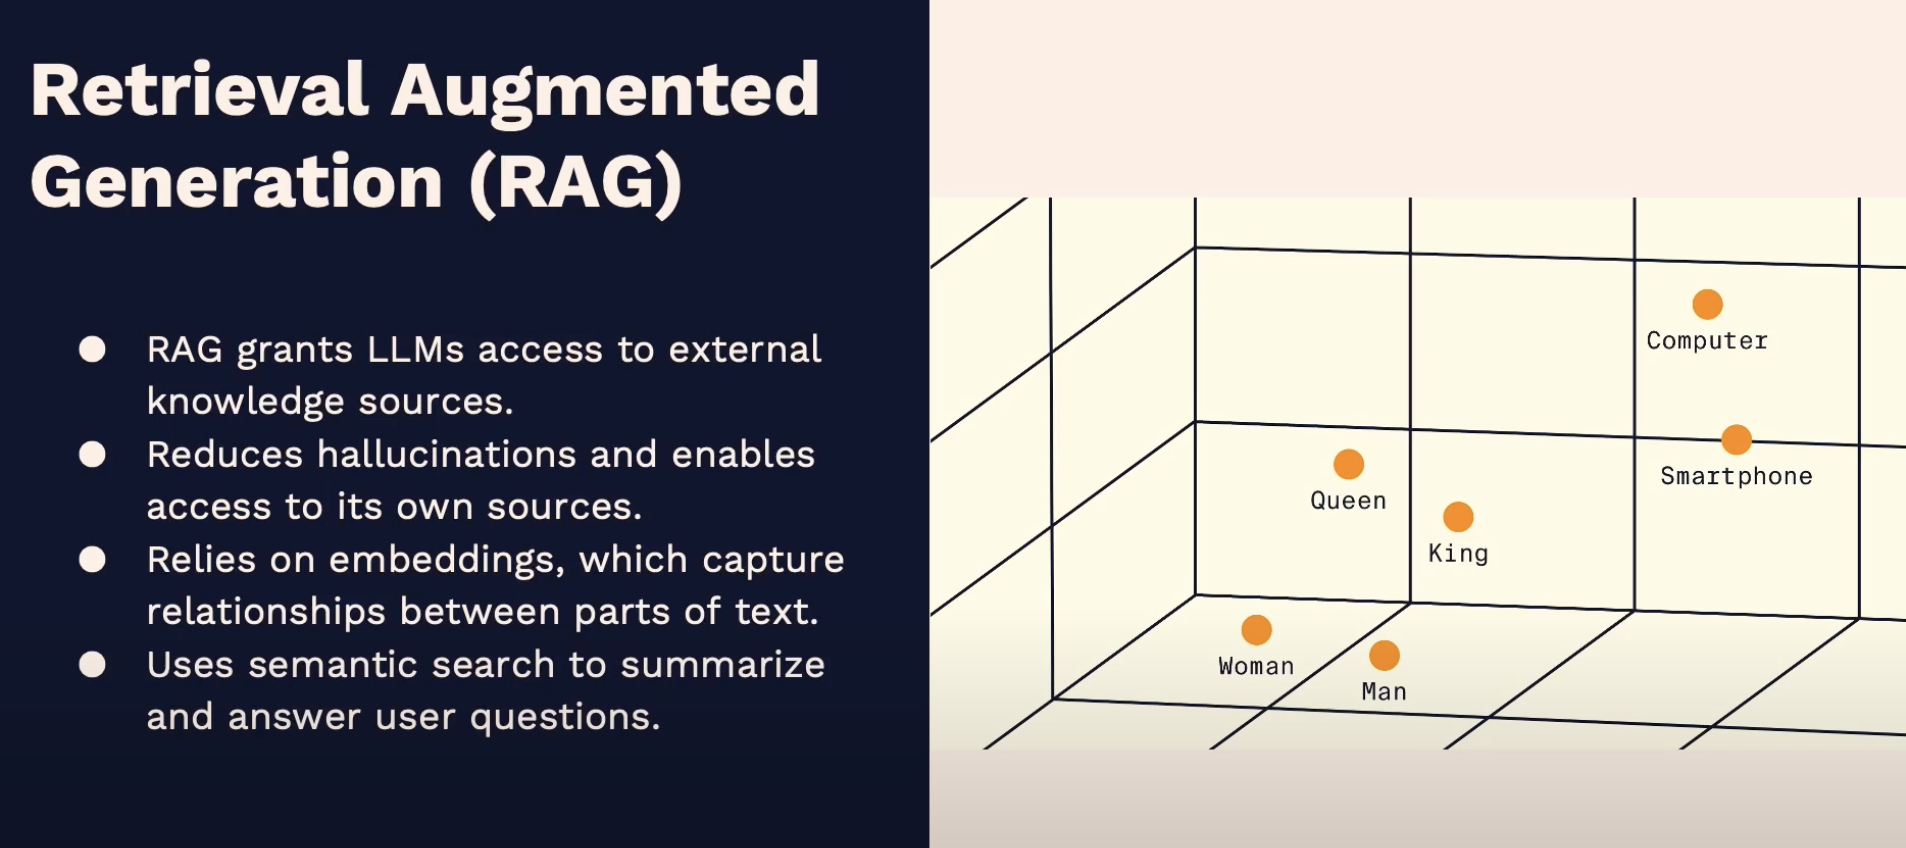

**Embedding and Semantic Search**

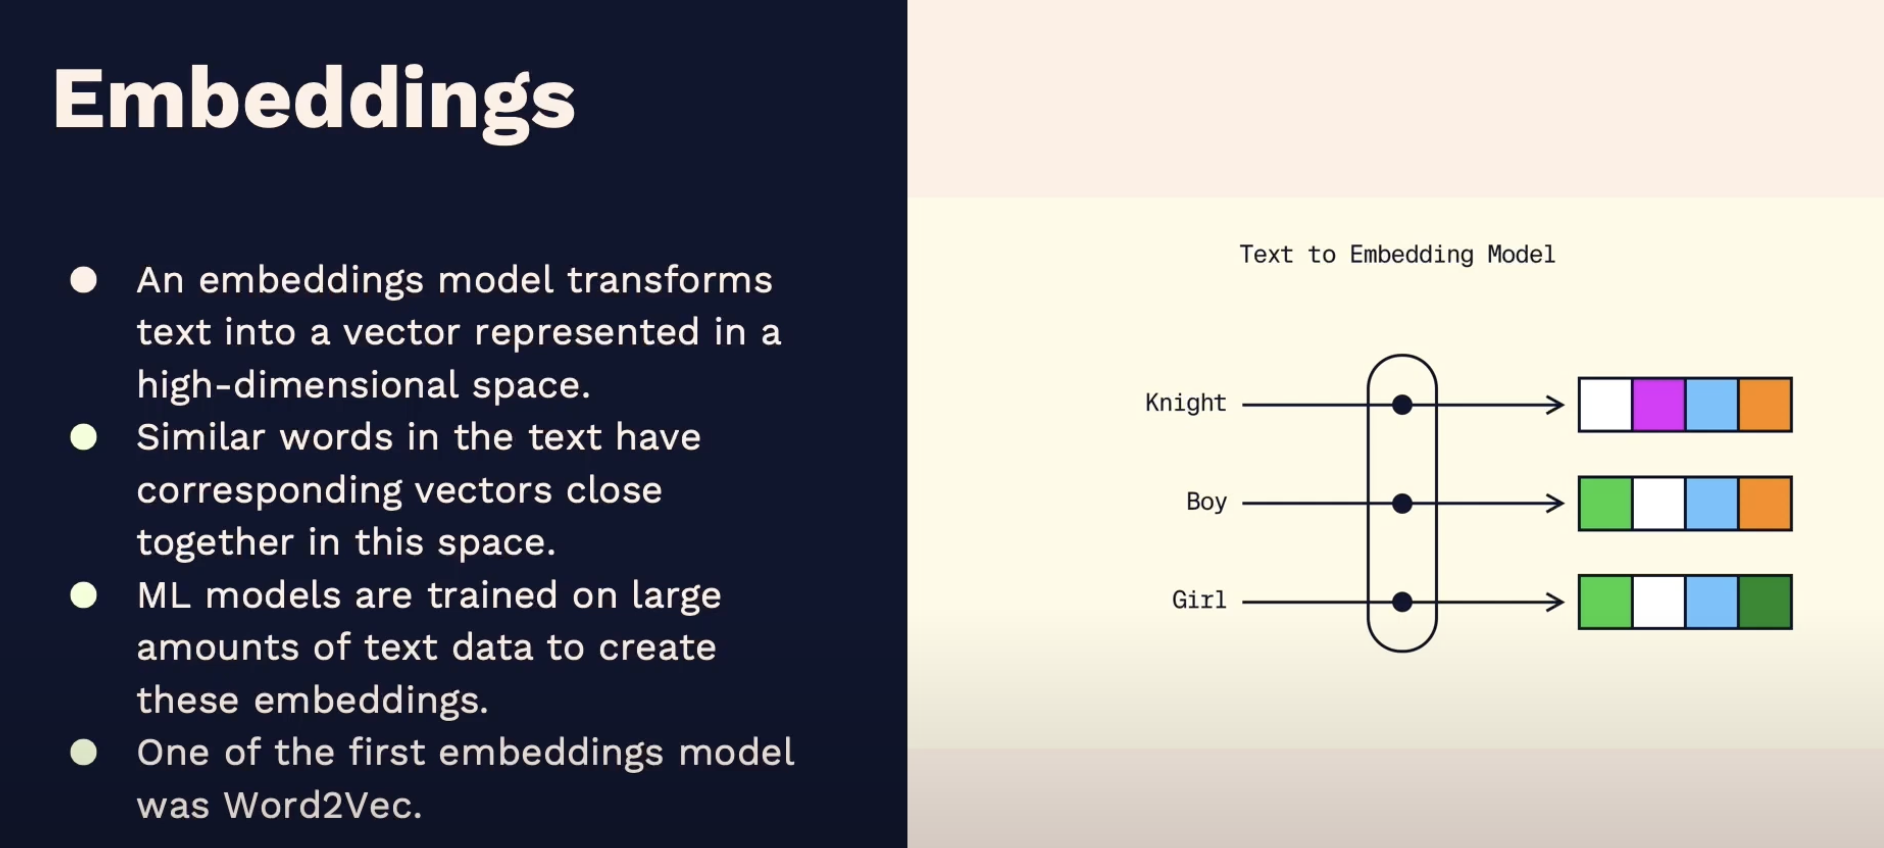

**Lets start by installing chromaDB in our jupyter notebook**

We will use langchain to call chromaDB

In [ ]:
!pip install chromadb

**We will start by importing ChromaDB first**

In [ ]:
import chromadb

Now, we will call the embedding function in chromaDB.

Run the setup cell to import our vector database and instantiate our embedding model.

In [ ]:
embedding_function = chromadb.utils.embedding_functions.DefaultEmbeddingFunction()

Embedding Strings

Now that we've received an introduction to the relevant concepts, let's practice performing some similarity search of our own.

First, we instantiate the all-MiniLM-L6-v2 embedding model from Sentence Transformers, which is included in the Chroma package by default. This pre-trained language model has 384 dimensions for each embedding, which means each piece of text will be represented by a 384-dimensional vector.

You can read more about this model here: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

Let's start by embedding a simple string of text using this model. Run the code cell below to see how to get the embedding for a string.

In [ ]:
embedding = embedding_function(["Welcome to the Zense session on generative AI!"])
print(embedding[0][:5]) # we only print the first five values to illustrate it.
# Print the length of the embedding to confirm it has 384 dimensions
print(len(embedding[0]))

[-0.13645403 -0.00140598  0.01740444  0.02616068  0.02706023]
384


Before we start how to access the content which we feeed into the RAG, we will need to install some libraries

**Prompt Engineering for RAG**

In [ ]:
pip install langchain-groq langchain-huggingface chromadb

The code below ensures that the Groq API key is available for use within the Python environment. If the key is not already set as an environment variable, it prompts the user to enter it securely and then stores it for future use.

Getpass helps you to securely enter the api keys for use.


In [4]:
import getpass
import os

if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("enter api key: ")

enter api key: ··········


In [ ]:
pip install -U langchain-community

In [ ]:
!pip install wikipedia

**We will start by reusing some code we went over in previous exercises:** loading and splitting text data from files, storing the chunks in a Chroma collection with metadata using Groq chat as the client. We then query the collection to retrieve the most relevant chunk for a given question.

In [ ]:
import chromadb
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_groq import ChatGroq
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
import wikipedia
import os

# Initialize Groq
groq_chat = ChatGroq(
    api_key=os.environ["GROQ_API_KEY"],
    model_name="mixtral-8x7b-32768",
    temperature=0.7,
    max_tokens=5500
)

**MAX_TOKENS**
Limits the maximum number of tokens that the model can generate in a single response.

Tokens: Represent units of text, such as words or parts of words.

In [ ]:
# Initialize ChromaDB
chroma_client = chromadb.PersistentClient(path="./chroma_db")

# Initialize text splitter
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", "? ", "! "],
    chunk_size=2000,
    chunk_overlap=400,
)

# Initialize HuggingFace embeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Sample articles
articles = [
    {
        "title": "You (TV series)",
        "url": "https://en.wikipedia.org/wiki/You_(TV_series)"
    },
    {
        "title": "Breaking Bad",
        "url": "https://en.wikipedia.org/wiki/Breaking_Bad"
    },
    {
        "title": "Dark (TV series)",
        "url": "https://en.wikipedia.org/wiki/Dark_(TV_series)"
    }
]



PersistentClient is used to interact with a persistent ChromaDB collection.

The path="./chroma_db" argument specifies the directory where the ChromaDB collection will be stored on your local machine.

**TextSplitter** is used to break down large pieces of text into smaller, more manageable chunks.

**Arguments:**
1. separators: A list of characters or strings that will be used to split the text.

2. chunk_size: The desired size of each chunk in characters.

3. chunk_overlap: The number of characters that should overlap between consecutive chunks.

In [ ]:
# Process and store documents
documents = []
metadatas = []

for idx, article in enumerate(articles):
    try:
        # Fetch content from Wikipedia
        wiki_content = wikipedia.page(article["title"]).content
        chunks = text_splitter.split_text(wiki_content)

        for chunk_idx, chunk in enumerate(chunks):
            documents.append(chunk)
            metadatas.append({
                "chunk_idx": chunk_idx,
                "url": article["url"],
                "title": article["title"],
                "doc_id": f"{idx}-{chunk_idx}"
            })
    except Exception as e:
        print(f"Error fetching {article['title']}: {str(e)}")



In [ ]:
# Create Chroma vectorstore
vectorstore = Chroma.from_texts(
    texts=documents,
    embedding=embeddings,
    metadatas=metadatas,
    client=chroma_client,
    collection_name="tv_series_summaries"
)

# Create QA chain
qa_chain = RetrievalQA.from_chain_type(
    llm=groq_chat,
    chain_type="stuff",
    retriever=vectorstore.as_retriever()
)

# Query example
def query_documents(question: str):
    result = qa_chain.invoke({"query": question})
    return result["result"]

# Example usage
response = query_documents("Who does Joe pose as in the fourth season and what job did he take on?")
print(response)

# Cleanup (optional)
chroma_client.delete_collection("tv_series_summaries")